In [1]:
!nvidia-smi

Sat May  4 18:37:18 2024       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA A100-SXM4-80GB          On  |   00000000:01:00.0 Off |                    0 |
| N/A   34C    P0             66W /  500W |       0MiB /  81920MiB |      0%   E. Process |
|                                         |                        |             Disabled |
+-----------------------------------------+-----

In [2]:
from __future__ import annotations
from typing import Optional

from pathlib import Path
from datetime import datetime
import time

import numpy as onp
import jax.numpy as jnp
import jax.random as jr
import optax
from sklearn.model_selection import StratifiedGroupKFold

from tensorflow_probability.substrates import jax as tfp
tfd = tfp.distributions

import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

from dtd.model3d import DirichletTuckerDecomp

/home/users/swl1/.local/lib/python3.9/site-packages/urllib3/__init__.py:34: NotOpenSSLWarning: urllib3 v2.0 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 3.2.1'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


In [3]:
PROJECT_NAME = 'kf-dtd-240504'
DEFAULT_LR_SCHEDULE_FN = (
    lambda n_minibatches, n_epochs:
        optax.cosine_decay_schedule(
            init_value=1.,
            alpha=0.,
            decay_steps=n_minibatches*n_epochs,
            exponent=0.8,
        )
)

def get_unique_path(fpath, fmt='02d'):
    i = 1
    while fpath.is_file():
        stem = '-'.join(fpath.stem.split('-')[:-1])
        fpath = fpath.parent / f'{stem}-{i:{fmt}}{fpath.suffix}'
        i += 1
    return fpath

# ============================================================================ #
#                               FIT & EVALUATION                               #
# ============================================================================ #

def make_random_mask(key, shape, train_frac=0.8):
    """Make binary mask to split data into train (1) and test (0) sets."""
    return jr.bernoulli(key, train_frac, shape)

In [4]:
def load_data(data_dir: Path,
              max_samples: int=-1,
              verbose: Optional[bool]=False):
    """Load data tensor 
    
    Load data and metadata, and concatenate it along axis=0.
    
    Parameters
        data_dir: Directory containining .npz files of count tensors
        max_samples: Maximum number of total days/sessions of data to load.
            Loaded data is truncated; used for limiting dataset size for debugging.

    Returns
        total_counts: int. Normalized count value of data tensor
        X: UInt[Array, "n_samples n_bins n_syllables"]
        ages: Int[Array, "n_samples"]
        names: Object[Array, "n_samples"] 
        lifespan_labels: Object[Array, "n_samples"]
    """
    # These are data attributes that we would like to pass into the model.
    # Currently, this is not fully supported, so we hardcode them here.
    batch_axes, event_axes = (0,1), (2,)

    # Load data tensor and its metadata from all files in data_dir, concatenate
    #   X: UInt array, (n_samples, n_bins, n_syllables).
    #   ages: list, (n_samples,). Age/days since hatch.
    #   names: list, (n_samples,). Subject names, in long form.
    if verbose: print("Loading data...",end="")
    fpath_list = sorted([f for f in Path(data_dir).rglob("*") if f.is_file()])

    X, subject_ages, subject_names, lifespan_labels = [], [], [], []
    for fpath in fpath_list:
        fpath = Path(fpath)

        with jnp.load(fpath) as f:
            n_days_recorded = len(f['counts'])
            
            X.append(f['counts'])
            subject_ages.append(f['session_ids'])
            subject_names.append([fpath.stem[3:],]*n_days_recorded)

            # Assign a rough lifespan "class" label
            if f['session_ids'][-1] < 120:
                lbl = 'short'
            elif f['session_ids'][-1] < 280:
                lbl = 'median'
            else:
                lbl = 'long'
            lifespan_labels.append([lbl,]*n_days_recorded)
            
    
    X = jnp.concatenate(X, axis=0)[:max_samples]
    subject_ages = onp.concatenate(subject_ages)[:max_samples]
    subject_names = onp.concatenate(subject_names)[:max_samples]
    lifespan_labels = onp.concatenate(lifespan_labels)[:max_samples]
    if verbose: print("Done.")

    # Get total counts. Event axes are, by dimension, the axes along which
    # the data tensor X sums to a constant number.
    total_counts = X.sum(axis=event_axes)
    assert jnp.all(total_counts==total_counts.reshape(-1)[0]), \
        f'Expected data tensor to have a normalized number of counts along the event dimensions {event_axes}.'
    total_counts = int(total_counts.reshape(-1)[0])

    return total_counts, X, subject_ages, subject_names, lifespan_labels

In [5]:
def evaluate_fit(model, X, mask, params, verbose=False):
    """Compute heldout log likelihood and percent deviation from saturated model."""

    # Compute test log likelihood
    if verbose: print("Evaluating fit...", end="")
    test_ll = model.heldout_log_likelihood(X, mask, params)

    # Compute test ll under baseline model (average syllable usage across all held-in samples)
    # - baseline_probs: (D3,)
    baseline_probs = jnp.mean(X[mask], axis=0)
    baseline_probs /= baseline_probs.sum(axis=-1, keepdims=True)
    baseline_test_ll = \
        tfd.Multinomial(model.C, probs=baseline_probs).log_prob(X[~mask]).sum()

    # Compute test ll under under saturated model (true empirical syllable usage)
    # - saturated_probs = X / total_counts: (D1, D2, D3)
    saturated_probs = X / X.sum(axis=-1, keepdims=True)
    saturated_test_ll = \
        jnp.where(~mask, tfd.Multinomial(model.C, probs=saturated_probs).log_prob(X), 0.0).sum()

    # Compute test log likelihood fraction deviation explained of fitted model from
    # saturated model (upper bound), relative to baseline (lower bound).
    frac_dev_explained = (test_ll - baseline_test_ll) / (saturated_test_ll - baseline_test_ll)
    if verbose: print("Done.")

    return frac_dev_explained, test_ll, baseline_test_ll, saturated_test_ll

In [6]:
def fit_model(key, method, X, mask, total_counts, k1, k2, k3, alpha=1.1,
              lr_schedule_fn=None, minibatch_size=1024, n_epochs=100, drop_last=False,
              wnb=None, verbose=False):
    """Fit 3D DTD model to data using stochastic fit algoirthm.

    (New) parameters
        lr_schedule_fn: Callable[[int, int], optax.Schedule]
            Given `n_minibatches` and `n_epochs`, returns a function mapping step
            counts to learning rate value.
        minibatch_size: int
            Number of samples per minibatch.
        n_epochs: int
            Number of full passes through the dataset to perform
        wnb: wandb.Run or None
            WandB Run instance for logging metrics per epoch
    """

    key_init, key_fit = jr.split(key)

    # Construct a model
    model = DirichletTuckerDecomp(total_counts, k1, k2, k3, alpha)

    # -----------------------------------------------------------------------------------
    # Randomly initialize parameters
    # -----------------------------------------------------------------------------------
    if verbose: print("Initializing model...", end="")
    d1, d2, d3 = X.shape
    init_params = model.sample_params(key_init, d1, d2, d3)
    if verbose: print("Done.")

    # -----------------------------------------------------------------------------------
    # Fit model to data with EM
    # -----------------------------------------------------------------------------------
    if verbose: print(f"Fitting model with {method} EM...", end="")
    if method == 'stochastic':
        # Set default learning rate schedule function if none provided
        lr_schedule_fn = lr_schedule_fn if lr_schedule_fn is not None else DEFAULT_LR_SCHEDULE_FN

        params, lps = model.stochastic_fit(X, mask, init_params, n_epochs,
                                           lr_schedule_fn, minibatch_size, key_fit,
                                           drop_last=drop_last, wnb=wnb)
    else:
        params, lps = model.fit(X, mask, init_params, n_epochs, wnb=wnb)

    if verbose:  print("Done.")

    # -----------------------------------------------------------------------------------
    # Evaluate the model on heldout samples
    # -----------------------------------------------------------------------------------
    if verbose: print("Evaluating model fit...", end="")
    frac_dev_explained, test_ll, baseline_test_ll, saturated_test_ll \
                                        = evaluate_fit(model, X, mask, params)
    
    # Sort the model by principal factors of variation
    params, lofo_test_lls = model.sort_params(X, mask, params)

    if verbose:  print("Done.")

    # -----------------------------------------------------------------------------------
    # Return results
    # -----------------------------------------------------------------------------------
    n_train = mask.sum()
    n_test = (~mask).sum()
    return dict(G=params[0],
                F1=params[1],
                F2=params[2],
                F3=params[3],
                mask=mask,
                avg_train_lps=lps/n_train,
                avg_test_ll=test_ll/n_test,
                avg_baseline_test_ll=baseline_test_ll/n_test,
                avg_saturated_test_ll=saturated_test_ll/n_test,
                avg_lofo_test_ll_1=lofo_test_lls[0]/n_test,
                avg_lofo_test_ll_2=lofo_test_lls[1]/n_test,
                avg_lofo_test_ll_3=lofo_test_lls[2]/n_test,
               )

# def make_visual_summary(F1, F2, F3, frac_dev_1, frac_dev_2, frac_dev_3):

#     fig = plt.figure(figsize=(8.5,11), dpi=120)
#     gs_main = mpl.gridspec.GridSpec(nrows=3, ncols=1, height_ratios=[0.5,2,1], hspace=0.5)
    
#     # -----------------------------------------------------------------------------------
#     # Fraction deviation explained
#     # -----------------------------------------------------------------------------------
#     gs_lofo = gs_main[0].subgridspec(nrows=1, ncols=3)
#     for i, (name, frac_dev) in enumerate([('aging factors', frac_dev_1),
#                                           ('circadian bases', frac_dev_2),
#                                           ('behavioral topics', frac_dev_3)]):
#         ax = fig.add_subplot(gs_lofo[0,i])

#         # Draw frac deviation and reference (y=0)
#         ax.plot(frac_dev, marker='.', color='k')
#         ax.axhline(0, alpha=0.4, color='k', lw=1)

#         # Formatting
#         if i == 0: ax.set_ylabel('frac dev from baseline')
            
#         ax.set_title(name, fontsize='medium')
#         ax.tick_params(labelsize='small')
        
#         sns.despine(ax=ax)

#     # -----------------------------------------------------------------------------------
#     # Behavioral syllables
#     # -----------------------------------------------------------------------------------
#     ax = fig.add_subplot(gs_main[1])

#     K, D = F3.shape
#     draw_syllable_factors(F3, autosort=False, ax=ax, im_kw={'cmap': 'Greys', 'norm': mpl.colors.LogNorm(0.5*1/D, 1.0)})
#     ax.text(0.5, 1.1, 'behavioral syllables', transform=ax.transAxes, ha='center')
    
#     # Label each factor with fraction deviation explained
#     ax.set_yticks(onp.arange(K), minor=True)
#     ax.set_yticklabels([f'{frac:+.2f}' for frac in frac_dev_3], minor=True)
#     ax.tick_params(which='minor', axis='y', left=False, right=True, labelleft=False, labelright=True, labelsize='x-small')
    
#     # -----------------------------------------------------------------------------------
#     # Ciradian_bases
#     # -----------------------------------------------------------------------------------
#     D, K = F2.shape
#     gs2 = gs_main[2].subgridspec(nrows=K, ncols=1, hspace=0.1)
#     axs = [fig.add_subplot(gs2[k]) for k in range(K)]
#     draw_circadian_bases(F2, tod_freq='4H', autosort=False, axs=axs);
    
#     # Label each factor with fraction deviation explained
#     for ax, frac in zip(axs, frac_dev_2):
#         ax.text(1.02, 0.5, f'{frac:+.2f}', transform=ax.transAxes, ha='left',
#                 fontsize='x-small', va='center',
#                 bbox=dict(facecolor='white', alpha=0.1, pad=2))

#     return fig
    

In [7]:
def run_one(X, mask, total_counts, k1, k2, k3, alpha,
            init_seed, method='full', minibatch_size=1024, n_epochs=5000,
            max_samples=-1, drop_last=False, use_wandb=False, out_dir=None):
    """Fit data to one set of model parameters."""

    # If no seed provided, generate a random one based on the timestamp
    if init_seed is None:
        init_seed = int(datetime.now().timestamp())

    if use_wandb:
        wnb = wandb.init(
            project=PROJECT_NAME,
            config={
                'k1': k1,
                'k2': k2,
                'k3': k3,
                'alpha': alpha,
                'seed': init_seed,
                'method': method,
                'minibatch_size': minibatch_size,
                'max_samples': max_samples
            }
        )
        wandb.define_metric('avg_lp', summary='min')
        
        # Create a subdirectory at outdir based on run_id hash
        run_id = wandb.run.id
        out_dir = out_dir/run_id
        out_dir.mkdir(parents=True)
    else:
        wnb = None
        run_id = None
    
    # ==========================================================================

    run_start_time = time.time()

    key = jr.PRNGKey(init_seed)
    fit_results = fit_model(
            key, method, X, mask, total_counts, k1, k2, k3, alpha=alpha,
            minibatch_size=minibatch_size, n_epochs=n_epochs, drop_last=drop_last,
            wnb=wnb)

    run_elapsed_time = time.time() - run_start_time

    # ==========================================================================
    
    # Save results locally
    fpath_params = out_dir + '/params.npz'
    onp.savez_compressed(fpath_params,
                         init_seed=init_seed,
                         run_id=run_id,
                         **fit_results
                         )
    
    # Visualize parameters and save them
    frac_dev_1, frac_dev_2, frac_dev_3 = [
        (fit_results['avg_baseline_test_ll'] - lofo_test_ll) / fit_results['avg_baseline_test_ll']
        for lofo_test_ll in [fit_results['avg_lofo_test_ll_1'], fit_results['avg_lofo_test_ll_2'], fit_results['avg_lofo_test_ll_3']]
    ]

#     fig = make_visual_summary(fit_results['F1'], fit_results['F2'], fit_results['F3'],
#                               frac_dev_1, frac_dev_2, frac_dev_3)
#     fpath_viz = get_unique_path(out_dir/'summary.png')
#     plt.savefig(fpath_viz, bbox_inches='tight')
#     plt.close()

    # Log summry metrics. lps are automatically logged by model.stochastic_fit
    if use_wandb:
        frac_dev_explained = (fit_results['avg_test_ll'] - fit_results['avg_baseline_test_ll'])
        frac_dev_explained /= (fit_results['avg_saturated_test_ll'] - fit_results['avg_baseline_test_ll'])
        
        wnb.summary["frac_dev_explained"] = frac_dev_explained
        wnb.summary["avg_test_ll"] = fit_results['avg_test"ll']
        wnb.summary['run_time_min'] = run_elapsed_time/60

        wandb.save(str(fpath_topics), policy='now')
        wandb.save(str(fpath_bases), policy='now') 
        wandb.save(str(fpath_params), policy='now')
        wandb.finish()

    return

In [8]:
# ---------------------------------------------------------------------------------
# Load data
# ---------------------------------------------------------------------------------
data_dir = r"/scratch/groups/swl1/killifish/p3_20230726-20230915/q2-aligned_10min"
max_samples = -1

total_counts, X, subject_ages, subject_names, lifespan_labels \
                                    = load_data(data_dir, max_samples=max_samples)

# Convert UInt data tensor to float32 dtype
X = jnp.asarray(X, dtype=jnp.float32)
print(f"\tData array: shape {X.shape}, {X.nbytes/(1024**3):.1f}GB")
mask = jnp.ones(X.shape[:2], dtype=bool)


	Data array: shape (14410, 144, 100), 0.8GB


In [9]:
k1 = 256
k2 = 32
k3 = 64
alpha = 1.1
init_seed = 0
method = "stochastic"
drop_last = False
use_wandb = False
out_dir = r"/scratch/groups/swl1/killifish/swl1"
minibatch_size = 1024
n_epochs = 500

run_one(X, mask, total_counts, k1, k2, k3, alpha,
        init_seed, method=method, minibatch_size=minibatch_size, n_epochs=n_epochs,
        max_samples=max_samples, drop_last=drop_last, use_wandb=use_wandb, out_dir=out_dir)


Running 14 minibatches of size 1024.
Incomplete minibatch size of 74. drop_last=False,
epoch 0
epoch 1
epoch 2
epoch 3
epoch 4
epoch 5
epoch 6
epoch 7
epoch 8
epoch 9
epoch 10
epoch 11
epoch 12
epoch 13
epoch 14
epoch 15
epoch 16
epoch 17
epoch 18
epoch 19
epoch 20
epoch 21
epoch 22
epoch 23
epoch 24
epoch 25
epoch 26
epoch 27
epoch 28
epoch 29
epoch 30
epoch 31
epoch 32
epoch 33
epoch 34
epoch 35
epoch 36
epoch 37
epoch 38
epoch 39
epoch 40
epoch 41
epoch 42
epoch 43
epoch 44
epoch 45
epoch 46
epoch 47
epoch 48
epoch 49
epoch 50
epoch 51
epoch 52
epoch 53
epoch 54
epoch 55
epoch 56
epoch 57
epoch 58
epoch 59
epoch 60
epoch 61
epoch 62
epoch 63
epoch 64
epoch 65
epoch 66
epoch 67
epoch 68
epoch 69
epoch 70
epoch 71
epoch 72
epoch 73
epoch 74
epoch 75
epoch 76
epoch 77
epoch 78
epoch 79
epoch 80
epoch 81
epoch 82
epoch 83
epoch 84
epoch 85
epoch 86
epoch 87
epoch 88
epoch 89
epoch 90
epoch 91
epoch 92
epoch 93
epoch 94
epoch 95
epoch 96
epoch 97
epoch 98
epoch 99
epoch 100
epoch 101
epo

In [10]:
# load the results
results = onp.load("/scratch/groups/swl1/killifish/swl1/params.npz")

In [11]:
results["avg_train_lps"][-1].mean()

-3041.7563

In [12]:
list(results.keys())

['init_seed',
 'run_id',
 'G',
 'F1',
 'F2',
 'F3',
 'mask',
 'avg_train_lps',
 'avg_test_ll',
 'avg_baseline_test_ll',
 'avg_saturated_test_ll',
 'avg_lofo_test_ll_1',
 'avg_lofo_test_ll_2',
 'avg_lofo_test_ll_3']

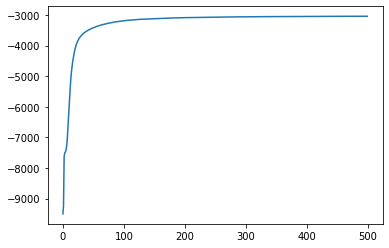

In [13]:
plt.plot(results["avg_train_lps"].mean(axis=1))

In [14]:
results["F1"].shape

(14410, 256)